In [2]:
# Load various imports
from datetime import datetime
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display

import numpy as np
import pandas as pd

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [3]:
shorten = True 
k = 8
mypath = 'C:/Users/Agraw/Downloads/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files'
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))] 
if shorten: filenames = filenames[0:int(len(filenames)/k)]
print(len(filenames))

115


In [4]:
p_id_in_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np.array(p_id_in_file)

In [5]:
filepaths = [join(mypath, f) for f in filenames] # full paths of files
p_diag=pd.read_csv('C:/Users/Agraw/Downloads/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',header=None)
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) # labels for audio files
# print(labels)
# print(len(labels))
'''

'''

# delete the very rare diseases, rewrite into same array for space? 
new_filepaths = np.delete(filepaths, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)
new_labels = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)
assert len(new_filepaths) == len(new_labels)

# print class counts
unique_elements, counts_elements = np.unique(new_labels, return_counts=True) 
#amt of values that have same value,  i.e. same class 
print(np.asarray((unique_elements, counts_elements)))

# print(len(new_filepaths), len(new_labels))


[['Bronchiectasis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
 ['4' '87' '7' '9' '5']]


In [6]:
train_fp, test_fp, label_train, label_test = train_test_split(new_filepaths, new_labels, stratify=new_labels, #doesnt work with features 

                                                    test_size=0.2, random_state = 42)

for d in unique_elements:
    files_trained = train_fp[np.argwhere(label_train ==d)]
    files_tested = test_fp[np.argwhere(label_test ==d)]

    print(len(files_trained), len(files_tested))
    

3 1
69 18
6 1
7 2
4 1


In [7]:
'''
DATA AUGMENTATION FUNCTIONS 
'''

'\nDATA AUGMENTATION FUNCTIONS \n'

In [8]:
def add_noise(data):
    noise_value = 0.015 * np.random.uniform() * np.amax(data)   # 1.5% with variation from 0-1 with emphasis on 0.5 of the maximum value 
    data = data + noise_value * np.random.normal(size=data.shape[0])   # Add noise to the data
    return data

In [9]:
def stretch_process(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8) #elongate data

In [10]:
def pitch_process(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor) # Shifts the pitch of the audio data by a specified number of semitones.
#this shift is very subtle, 0.7 of a semitone is less than 1/12 of a octave. barely any change jjust a little 

In [11]:
'''
DATA PROCESS FUNCTIONS 
'''

'\nDATA PROCESS FUNCTIONS \n'

In [12]:
def extract_process(data, sample_rate, debug=False):
    output_result = np.array([])
    #amt of times  signal crosses zero (measuring silence) 
    mean_zero = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0) 
    if debug: print('mean_zero shape',mean_zero.shape) 
    #you can horizontally add elements that have the same amount of rows without having to flatten the array
    '''
    [1] + [2] = [1,2]   
    [1,2]   [3]   [1, 2, 3]
    [1,2] + [3] = [1, 2, 3,]
    '''
    output_result = np.hstack((output_result, mean_zero)) 
    #positive of all values + short time ft (measuring loudness)  + zero crossing rate (measuring silence) 
    stft_out = np.abs(librosa.stft(data))
    if debug: print('stft_out shape', stft_out.shape) 
    '''
    Chroma features represent the energy content of the audio signal across different pitch classes 
    (the 12 unique notes in an octave, regardless of octave). 
    This is useful in music analysis for identifying harmonies and chords.
    
    The chroma_stft variable will contain a single value for each of the 12 pitch classes, 
    summarizing how much energy is present in each pitch class across the entire audio signal.
    This is important for music analysis tasks, as it helps capture the harmonic structure of the audio.
    '''
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft_out, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, chroma_stft))
    if debug: print('chroma_stft shape',chroma_stft.shape) 
    
    mfcc_out = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    output_result = np.hstack((output_result, mfcc_out))
    if debug: print('mfcc_out shape',mfcc_out.shape) 
    '''
    The root_mean_out variable contains a single average RMS value that summarizes the overall loudness or energy level of the audio signal.
    This feature is particularly useful for understanding dynamic variations in the audio, such as changes in loudness over time.
    '''
    root_mean_out = np.mean(librosa.feature.rms(y=data).T, axis=0)
    output_result = np.hstack((output_result, root_mean_out)) 
    if debug:  print('root_mean_out shape',root_mean_out.shape) 

    mel_spectogram = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, mel_spectogram))
    if debug:  print('mel_spectogram shape',mel_spectogram.shape) 


    return output_result


In [13]:
def extract_features(file_name, debug=False):
    """
    This function takes in the path for an audio file as a string, loads it,
    and extracts several audio features including mean values of MFCC, Zero Crossing Rate,
    Chromagram, Root Mean Square Energy, and Mel Spectrogram from the original and its augmented versions.
    
    create argument for extraction == false,  to return the original audio file instead of the augmented one. 

    """
    try:
        # Load the original audio file
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=42, offset=0.6)
        if debug: print(sample_rate)
        assert  sample_rate == 22050, "Sample rate is not 22050" 


        # Extract features from the original audio data
        extracted_features = extract_process(audio, sample_rate, debug=False)
        result = np.array(extracted_features)

        # Add noise and extract features
        noise_out = add_noise(audio)
        output_2 = extract_process(noise_out, sample_rate)
        result = np.vstack((result, output_2))

        # Time-stretch and then pitch-shift before extracting features
        new_out = stretch_process(audio,0.8)
        stretch_pitch = pitch_process(new_out, sample_rate,pitch_factor=0.7)
        output_3 = extract_process(stretch_pitch, sample_rate)
        result = np.vstack((result, output_3))

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print("Error Details:", e)
        return None

    return result




In [14]:
t = extract_features(filepaths[0]) 
t.shape

(3, 182)

In [15]:
'''
DATA PROCESS AND ENGINEERING
'''

'\nDATA PROCESS AND ENGINEERING\n'

In [16]:
training_features = []
testing_features =[]
#randomize file paths
# Iterate through each sound file and extract the features
for file_name in train_fp:
    data = extract_features(file_name)
    #print(data) -> too much data; will take long  time to print 
    training_features.append(data) 
for file_name in test_fp:
    data = extract_features(file_name)
    #print(data) -> too much data; will take long  time to print 
    testing_features.append(data) 
#------------------------------------------------------------------------------
print('Finished feature extraction from ', len(training_features), ' files')
print('Finished feature extraction from ', len(testing_features), ' files')

Finished feature extraction from  89  files
Finished feature extraction from  23  files


In [17]:
training_features = np.array(training_features)
print('training_features:',training_features.shape)
testing_features = np.array(testing_features)
print('testing_features:',testing_features.shape)

training_features: (89, 3, 182)
testing_features: (23, 3, 182)


In [18]:
# # delete the very rare diseases, rewrite into same array for space? 
# new_features = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

# new_labels = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

In [19]:
# # print class counts
# unique_elements, counts_elements = np.unique(new_labels, return_counts=True) 
# #amt of values that have same value,  i.e. same class 
# print(np.asarray((unique_elements, counts_elements)))

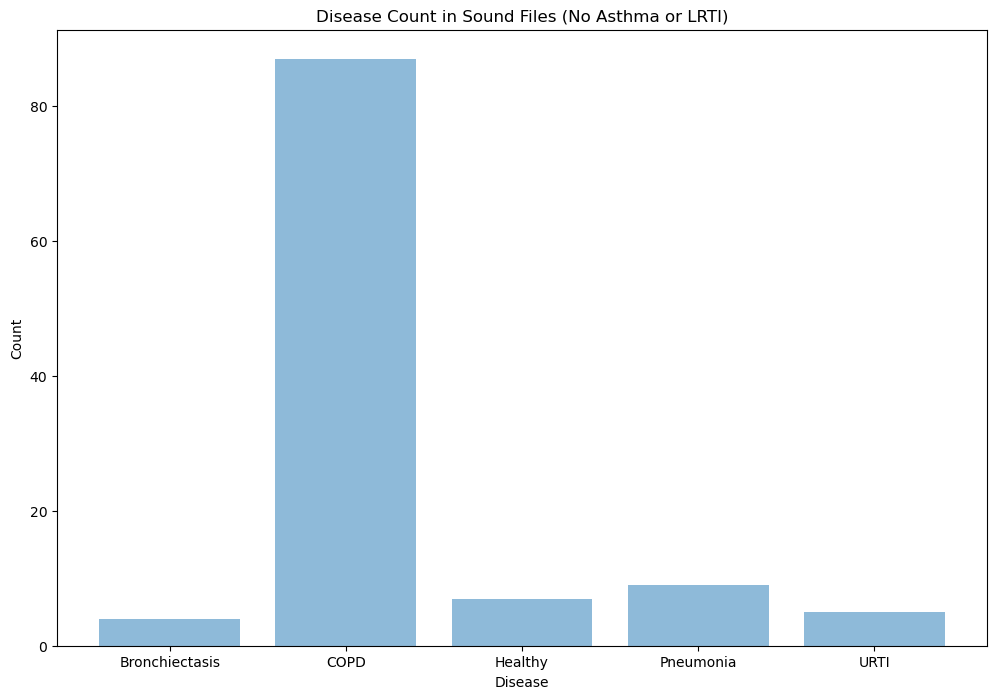

In [20]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files (No Asthma or LRTI)')
plt.show()

In [21]:
flattened_testfeatures = testing_features.reshape(-1, 182) #test train
print('flattened_testfeatures',flattened_testfeatures.shape)
flattened_trainfeatures = training_features.reshape(-1,182)
print('flattened_trainfeatures',flattened_trainfeatures.shape)
#[0,0,0,1,1,1,2,2,2,3,3,3,4,4,4]

flattened_testfeatures (69, 182)
flattened_trainfeatures (267, 182)


In [22]:
augmented_test_labels = np.repeat(label_test, 3)   # Repeat labels 3 times for test train 
augmented_train_labels = np.repeat(label_train, 3)   # Repeat labels 3 times for test train 
print(augmented_test_labels.shape)
print(augmented_train_labels.shape)

(69,)
(267,)


In [23]:
# augmented_features = np.reshape(features, (-1, 182))  # Flatten the feature sets

# mask = ~np.isin(augmented_labels, ['Asthma', 'LRTI']) #determine the difference between two sets of values. 
# augmented_features = augmented_features[mask]  #filter out the values that are not in the mask
# augmented_labels = augmented_labels[mask]   #filter out the values that are not in the mask


In [24]:
le = LabelEncoder()
'''
Fit: It learns the unique categories and assigns them a unique integer value (starting from 0).
Transform: It converts the original categorical data into the corresponding integers
'''
i_testlabels = le.fit_transform(augmented_test_labels)
i_trainlabels = le.fit_transform(augmented_train_labels)
#oh label test train 
oh_testlabels = to_categorical(i_testlabels) #using onehot encoding to convert labels into binary format 
oh_trainlabels = to_categorical(i_trainlabels) #using onehot encoding to convert labels into binary format 



In [25]:
print(i_testlabels.shape)
print(i_trainlabels.shape)
print(oh_testlabels.shape)
print(oh_trainlabels.shape)

(69,)
(267,)
(69, 5)
(267, 5)


In [26]:
# train test split
'''
# '''
# x_train = flattened_features[0:2200]
# x_test  = flattened_features[2200:] 
# y_train = oh_labels[0:2200]
# y_test =  oh_labels[2200:]


# x_train, x_test, y_train, y_test = train_test_split(flattened_features, oh_labels, stratify=oh_labels, #doesnt work with features 

#                                                     test_size=0.2, random_state = 42)



'\n# '

In [27]:
#SCALER & TRANSFORMATION
scaler_data = StandardScaler()

In [28]:
print(flattened_testfeatures.shape)
print(oh_testlabels.shape)
print(flattened_trainfeatures.shape)
print(oh_trainlabels.shape)

(69, 182)
(69, 5)
(267, 182)
(267, 5)


In [1]:
x_train = scaler_data.fit_transform(flattened_trainfeatures)
x_test = scaler_data.transform(flattened_testfeatures)
y_train = oh_trainlabels
y_test = oh_testlabels

NameError: name 'scaler_data' is not defined

In [71]:
x_train = np.expand_dims(x_train,axis=2)
x_test = np.expand_dims(x_test,axis=2)
#cnn model takes 3 dimensions, creating empty column for cnn to read 
#cnn format h,w,channel (needs 3 dimensions for each parameter)
#channel first vs channel last (defakt) -> typically used in image processing (such as 3 primary colors [3 channels])

In [72]:
'''
1D CNN MODEL
'''

'\n1D CNN MODEL\n'

In [73]:
from tensorflow.keras import layers, Sequential

num_labels = len(np.unique(new_labels))  # Determine the number of unique classes

'''
right now doing feature extract, want to use only raw data and make new model 
'''

Model = Sequential([
    layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(units=32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(units=num_labels, activation='softmax')
])

In [74]:
Model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor="loss",patience=100,mode="min")


In [93]:
import os

checkpoint_path_1 = "training_1/cp-{epoch:04d}.ckpt"
checkpoint_dir_1 = os.path.dirname(checkpoint_path_1)

# Print the full path of the checkpoint directory
print("Checkpoint Directory:", os.path.abspath(checkpoint_dir_1))

# Create the directory if it doesn't exist
if not os.path.exists(checkpoint_dir_1):
    os.makedirs(checkpoint_dir_1)

# Define the ModelCheckpoint callback
checkpoint_callback_1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_1, 
    verbose=1, 
    save_weights_only=True, 
    save_freq='epoch'
)

Checkpoint Directory: c:\Users\Agraw\denoise_speech\demo_work\py_files\training_1


In [95]:
Model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stop, checkpoint_callback_1])

latest = tf.train.latest_checkpoint(checkpoint_dir_1)
if latest:
    Model.load_weights(latest)
    print(f"Loaded weights from {latest}")
else:
    print("No checkpoint found. Please check the checkpoint directory.")
    
print("Files in checkpoint directory", len(os.listdir(checkpoint_dir_1)))

Epoch 1/50
4/5 [=======================>......] - ETA: 0s - loss: 6.5362e-04 - accuracy: 1.0000
Epoch 1: saving model to training_1\cp-0001.ckpt
5/5 [==============================] - 1s 150ms/step - loss: 6.2691e-04 - accuracy: 1.0000 - val_loss: 4.4158 - val_accuracy: 0.8696
Epoch 2/50
4/5 [=======================>......] - ETA: 0s - loss: 1.9201e-04 - accuracy: 1.0000
Epoch 2: saving model to training_1\cp-0002.ckpt
5/5 [==============================] - 1s 127ms/step - loss: 1.8410e-04 - accuracy: 1.0000 - val_loss: 4.4263 - val_accuracy: 0.8696
Epoch 3/50
4/5 [=======================>......] - ETA: 0s - loss: 5.9143e-06 - accuracy: 1.0000
Epoch 3: saving model to training_1\cp-0003.ckpt
5/5 [==============================] - 1s 119ms/step - loss: 6.1774e-06 - accuracy: 1.0000 - val_loss: 4.4448 - val_accuracy: 0.8696
Epoch 4/50
4/5 [=======================>......] - ETA: 0s - loss: 1.0491e-05 - accuracy: 1.0000
Epoch 4: saving model to training_1\cp-0004.ckpt
5/5 [================

In [35]:
Model_Results = Model.evaluate(x_test,y_test)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.4f" % Model_Results[1])

3/3 [==============================] - 0s 12ms/step - loss: 1.7900 - accuracy: 0.8841
LOSS:  1.7900
ACCURACY:  0.8841


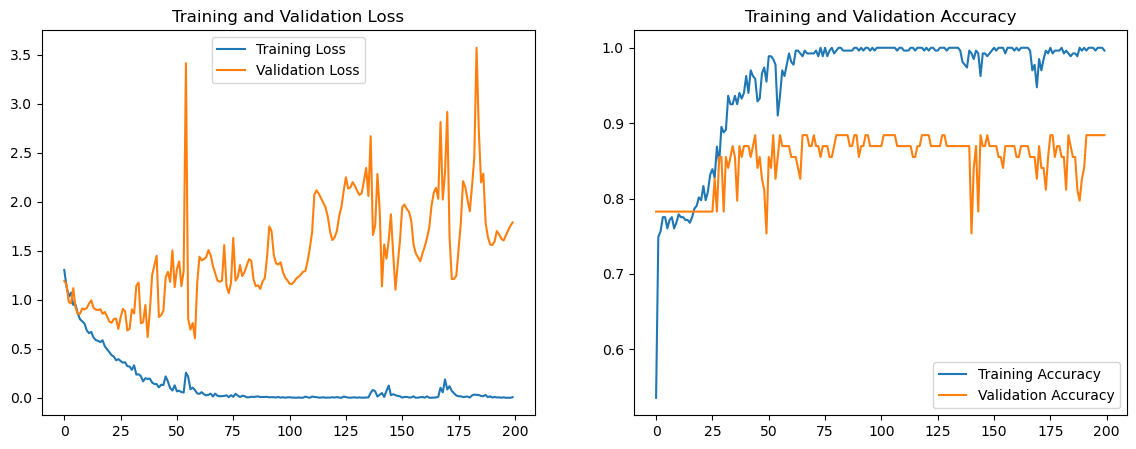

In [36]:
# Plotting loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(evConv1D_Model.history['loss'], label='Training Loss')
plt.plot(evConv1D_Model.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(evConv1D_Model.history['accuracy'], label='Training Accuracy')
plt.plot(evConv1D_Model.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


3/3 [==============================] - 0s 11ms/step
0.8436853002070392


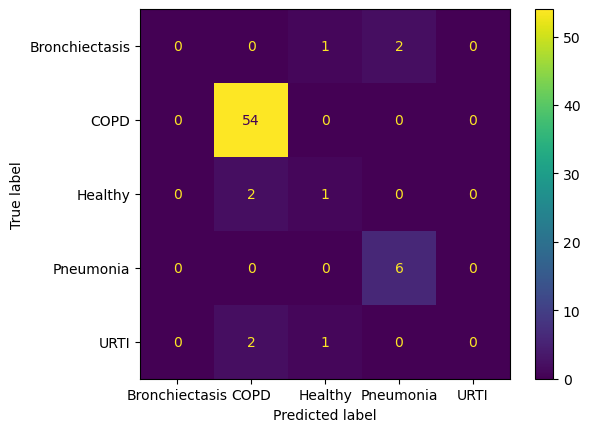

In [37]:
# Getting the predictions
import sklearn
y_pred = Model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generating the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Displaying the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_mtx, display_labels=le.classes_).plot()
print(sklearn.metrics.f1_score(y_true, y_pred_classes, average='weighted'))
